# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [1]:
## TODO
# Test adding 2-3 times as many negative rows to df for NN training
# Get ROC AUC
# Tune 

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix

### 1. Import Vectors and Pre-Process them

In [3]:
# Import vec file
with open('AllVectorResults.lst', 'r') as file:
    text = file.read()

In [4]:
# Strip and split it into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

In [5]:
# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']
# df.head()

In [6]:
# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

In [7]:
# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

### 2. Create DF for NN
From the ID-Vector dataframe we will now create a df matching each chem with each disease of the following columns:
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [8]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [9]:
# Step 2: Iterate through each chem and create a line for it with each dis

In [10]:
# We only want the chems and diseases that we have vectors for
df.shape

(2970, 2)

In [11]:
# Reshape chem_dis to to only keep lines where both chem and dis have a vec
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [12]:
# Now create a df:
# cID, dID, cVec, dVec, correlate?
# We'll build it on chem_dis...but all current relationships are positive. Need to create non-related pairs c-d
# out_df = chem_dis.copy()
# out_df['correlate'] = 1
# out_df.shape # 62015, should aim to make this many non-related associations too

In [13]:
# So iterate through vecs and create a line for it if there is a rel with a dis that has a vec
# chem_dis['dVec'] = np.nan
# chem_dis['cVec'] = np.nan
# chem_dis['dVec'] = np.where(df.ID == chem_dis.DiseaseID, df.Vector, None)

In [14]:
chem_dis.shape

(6660, 2)

In [15]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

In [16]:
df1['Correlation'] = 1 # currently only have correlated in there

In [17]:
## Commenting this out as I've switched to generating pairs from the df dataset (mixed corr and uncorr)
# # Randomly generate control set - pairs of unrelated diseases and chemicals and add as rows 
# # Change this to randomly select from df instead of chem_dis
# no_rows = df1.shape[0]-1
# print('shape: ', no_rows)
# for x in range(0, no_rows):
#     int1 = randint(0, df1.shape[0]-1)
#     int2 = randint(0, df1.shape[0]-1)
#     chem, chemvec = df1.loc[int1, 'ChemicalID'], df1.loc[int1, 'CVec']
#     dis, disvec = df1.loc[int2, 'DiseaseID'], df1.loc[int2, 'DVec']
#     df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)
    
# # Delete any duplicates induced in generating rows (note that this will remove any known correlations 
# # from the new rows)
# df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)

In [18]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [22]:
len(df_dis)

2558

In [23]:
np.random.choice(len(df_chems), 3, replace=True)

array([360,  22, 159])

In [24]:
# Add unrelated pairs to df1
no_rows = df1.shape[0]-1
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
np.random.seed(2302)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  6659
(13319, 5)
(13193, 5)


In [542]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [543]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C049584,MESH:D001943,"[-0.00754089653, 0.0284954235, -0.145941272, -...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
1,C049584,MESH:D018270,"[0.01976116, 0.098279193, 0.0369541571, -0.089...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
2,C049584,MESH:D019457,"[0.03360923, 0.10056757, 0.05314376, -0.113913...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
3,C049584,MESH:D003110,"[0.00136586, 0.13832065, 0.02338981, -0.113038...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
4,C049584,MESH:D015179,"[-0.02237691, 0.07948194, -0.09784327, -0.0321...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1


In [544]:
# # Split df into train, test, val
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [545]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [546]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [547]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (13167,)
X shape:  (13167, 400)


In [548]:
# Split into train, test, val
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [549]:
# type(X_train)

numpy.ndarray

### 3. Establish NN Model

In [594]:
# 1. Establish the model architecture
model = keras.Sequential([
    keras.layers.Dense(200, input_dim=400, activation=tf.nn.relu), #Dense layers are fully connected, this one 128 nodes
    keras.layers.Dense(200, activation=tf.nn.relu), #it's safe to say that I don't know what I'm doing here
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
# ??? How is the number of nodes decided? Final layer has no. of outcome vars

In [595]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [613]:
# 3. Train
model.fit(X_train, y_train, validation_split=0.2, epochs=6) # ??? How is the number of epochs decided, rule of thumb? elbow?

Train on 6740 samples, validate on 1686 samples
Epoch 1/6
6740/6740 [==============================] - 2s 363us/step - loss: 0.3870 - acc: 0.8257 - val_loss: 0.4109 - val_acc: 0.8155
Epoch 2/6
6740/6740 [==============================] - 2s 290us/step - loss: 0.3838 - acc: 0.8341 - val_loss: 0.4713 - val_acc: 0.7728
Epoch 3/6
6740/6740 [==============================] - 2s 223us/step - loss: 0.3723 - acc: 0.8364 - val_loss: 0.4490 - val_acc: 0.7805
Epoch 4/6
6740/6740 [==============================] - 2s 336us/step - loss: 0.3675 - acc: 0.8396 - val_loss: 0.4055 - val_acc: 0.8096
Epoch 5/6
6740/6740 [==============================] - 2s 332us/step - loss: 0.3765 - acc: 0.8355 - val_loss: 0.4085 - val_acc: 0.8161
Epoch 6/6
6740/6740 [==============================] - 2s 354us/step - loss: 0.3713 - acc: 0.8386 - val_loss: 0.4072 - val_acc: 0.8173


In [614]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2634/2634 [==============================] - 0s 189us/step
Test accuracy: 0.8211845102053116


In [609]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False        776   498     1274
True          78  1282     1360
__all__      854  1780     2634


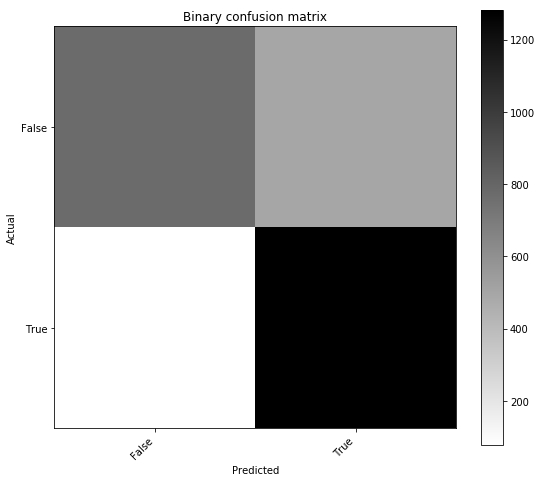

In [610]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [611]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8920577846523224


In [612]:
# # This is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

0.8101746393318148


### 4. Calculate Cosine Similary

In [555]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C049584,MESH:D001943,"[-0.00754089653, 0.0284954235, -0.145941272, -...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
1,C049584,MESH:D018270,"[0.01976116, 0.098279193, 0.0369541571, -0.089...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
2,C049584,MESH:D019457,"[0.03360923, 0.10056757, 0.05314376, -0.113913...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
3,C049584,MESH:D003110,"[0.00136586, 0.13832065, 0.02338981, -0.113038...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
4,C049584,MESH:D015179,"[-0.02237691, 0.07948194, -0.09784327, -0.0321...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1


In [606]:
# Calculate out the cosine similarity and see if there's a difference between groups (there isn't)
def cosine_sim (row):
    return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# Compare cosine sim of correlated and uncorrelated groups
print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

Cosine mean with no correlation:  0.8935658082143485
Cosine mean with correlation:  0.9284143086300267
